<a href="https://colab.research.google.com/github/sujithgunturu/Math799/blob/master/Jacobean_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
from scipy import interpolate
from scipy.integrate import odeint
import autograd.numpy as np
import autograd
from scipy.stats import multivariate_normal 
from scipy.integrate import solve_ivp

In [27]:
"""Model Class Definition"""
class Model(object):
    
    #Attributes we want each instance of model to have
    def __init__(self,Eqns):
        self.Eqns = Eqns  #
        #self.n_var = len(Eqns)
        self.solution=[]  # creates a new empty list for each model
        self.params=None   # Initialize parameter values
        
        self.y0=None      # Initialze initial state variables
        
        self.t=None       # Initialie array of times at which solutions are sought
        
        self.Env=None     # Set flag that the simulation environment is not yet defined
                          #    When it is, it will most likely be an array with one
                          #    row per measurement time and one column per environmental
                          #    variable.
        self.day_length=None
        
                    
    # Store a vector of desired solution times
    def new_soltimes(self,t):
        self.t=np.array(t)
    
    # Store a vector of desired state variable initial conditions
    def new_ICs(self,y0):
        self.y0=np.array(y0)
    
    # Store a vector of model parameters - this is used during parameter estimation
    def new_params(self,params):
        self.params=np.array(params)
        
    
    """ The following two methods are overloaded in the users class definition """
    
    # Fetch the environmental information from a file.  "Environ" is 
    # whatever information is needed to do this.
    def FetchEnviron(self,Environ):
        pass
        
    
  
    def GetEnvData(self,t):
        self.Edat=np.zeros(9)
        
        
    # Run the model
    def Run(self,ICs=None,params=None,t=None,Environ=None):
        
        # Perform any needed initializations
        if ICs is not None    : self.new_ICs(ICs)
        if params is not None : self.new_params(params)
        if t is not None      : self.new_soltimes(t)
        if Environ is not None: self.FetchEnviron(Environ)
        
        
        
        # if self.params is None or self.y0 is None or self.t is None or self.Env is None:
        #     raise Exception("Prequisite data for run is incomplete")
        
        # Define the function that is passed to odeint
        def deriv(y,t,model):
            
            # Obtain the environmental data for this value of t
            self.Edat
            # Compute required derivatives.  This will entail using data that
            # should be ready and waiting in model.par and model.Edat
            
            return model.Eqns(t, y, model.params, model)
            


        # Call odeint to itegrate diffeq system.  All the odeint arguments are shown
        # here in case we want to modify something in a future version.  (It is, perhaps,
        # noteworthy that some of the extra parameters apparenly specify the order of 
        # integration to be peformed.)
        
        return odeint(deriv,           # Computes the derivative of y at t
                      self.y0,         # Initial condition on y (can be a vector) 
                      self.t,          # The time points for which to solve for y
                      args=(self,),    # Extra arguments to pass to function (self reference to
                                       #   this model instance)
                      Dfun=None,       # Gradient (Jacobian) of func 
                      col_deriv=0,     # True if Dfun defines derivatives down columns
                      full_output=0,   # True if to return a dictionary of 
                                       #   optional outputs as the second output
                      printmessg=0,    # Whether to print the convergence message
                      tfirst=False,    # If True, the first two arguments of func 
                                       #   (and Dfun, if given) must t, y
                                
        #  See https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
        #     ror the definition of these arguments
        
                      ml=None,           
                      mu=None, 
                      rtol=None, 
                      atol=None, 
                      tcrit=None, 
                      h0=0.0, 
                      hmax=0.0, 
                      hmin=0.0, 
                      ixpr=0, 
                      mxstep=0, 
                      mxhnil=0, 
                      mxordn=12, 
                      mxords=5)

In [28]:
class osu_model(Model):
    def __init__(self,Eqns):
        Model.__init__(self,Eqns)
        #self.n_var = Model.n_var
    def FetchEnviron(self, Environ):
        file = Environ[0]
        
        # reading the data
        df = pd.read_csv(file)
    
        #RELHUM2MAVG
        x = self.t
        y = df["RELHUM2MAVG"][:100]
        
        self.W_ht = interpolate.interp1d(x, y, fill_value="extrapolate")


        #WSPD2MAVG
        y = df["WSPD2MAVG"][:100]
        self.W_wt = interpolate.interp1d(x, y, fill_value="extrapolate")


        #PRECIP
        y = df["PRECIP"][100:200]
       
        self.W_rt = interpolate.interp1d(x, y, fill_value="extrapolate")


        # (TEMP2MAVG)
        y = df["TEMP2MAVG"][:100]
        self.W_at = interpolate.interp1d(x, y, fill_value="extrapolate")


        #SR
        y = df["SR"][:100]
        self.W_st = interpolate.interp1d(x, y, fill_value="extrapolate")


        #PRESSUREAVG
        y = df["PHOTOPERIOD"][:100]
        self.W_pt1 = interpolate.interp1d(x, y, fill_value="extrapolate")

        #PHOTOPERIOD
        y = df["PRESSUREAVG"][:100]
        
        self.W_pt2 = interpolate.interp1d(x, y, fill_value="extrapolate")

        #TEMP2MMIN
        y = df["TEMP2MMIN"][:100]
        
        self.W_nt = interpolate.interp1d(x, y, fill_value="extrapolate")


        #TEMP2MMAX
        y = df["TEMP2MMAX"][:100]
        
        self.W_xt = interpolate.interp1d(x, y, fill_value="extrapolate")
        
        self.Edat = [self.W_ht, self.W_wt, self.W_rt, self.W_at, 
                     self.W_st, self.W_pt1, self.W_pt2, self.W_nt, 
                     self.W_xt]
        
        return  self.Edat




In [29]:
class Build_Jacobean(Model):
    def __init__(self, system, statevars, statevars0, parameters, paramvalues):
      self.system = system
      self.statevars = statevars
      self.statevars0 = statevars0
      self.parameters = parameters
      self.paramvalues = paramvalues

    def Run_Model(self, environ, t):
        self.Modelinstace= osu_model(self.system)
        self.Modelinstace.new_ICs(self.statevars0[:len(self.statevars)])
        self.Modelinstace.new_soltimes(t)
        self.Modelinstace.new_params(self.paramvalues)
        self.Modelinstace.FetchEnviron(environ)

        Jac_X = autograd.jacobian(self.system,argnum=1)
        Jac_P = autograd.jacobian(self.system,argnum=2)
        
        P = self.paramvalues
        n_vars = len(self.statevars)
        n_params = len(self.parameters)
        n_depend = n_vars*n_params
        def rhs_fn(X,t):                                    #for odeint
        #def rhs_fn(t,X):                                   #for solve_ivp
            # split into variables and parameter derivatives
            
            Xv = X[:n_vars]
            Xd = X[n_vars:].reshape((n_vars,n_params))

          # initialize the derivative vector
            d = np.zeros_like(X)
            # copy the original ODE part
          
            d[:n_vars] = self.system(t,Xv,P, self.Modelinstace)
            JX = Jac_X(t, np.array(Xv), np.array(P), self.Modelinstace)
            JP = Jac_P(t, np.array(Xv), np.array(P), self.Modelinstace)
            

            # find the RHS for the parameter derivatives and reflatten to a vector
            d[n_vars:] = (JX.dot(Xd) + JP).flatten()

            return d
        # initial conditions
        x0 = self.statevars0
        # solve the odes
        
        #soln = solve_ivp(rhs_fn, (t[0],t[-1]), x0, t_eval=t)
        soln = odeint(rhs_fn, x0, t)
        return soln

In [30]:
def rhs(t, X, P, model):
  S_vt, S_lt, S_at, S_wt, S_bt, S_yt, S_gt = X
  theta_vr,theta_vd,theta_vo,  theta_vs,theta_vq,theta_ps, theta_pr, theta_pm,theta_tr,theta_td,theta_t0,theta_alpha, theta_el,theta_k,theta_sr,theta_sm,theta_gx,theta_m,theta_gb,theta_ts,theta_rue,theta_a,S_xl,k_i,k_m,k_e  = P
  CV  = (1 + np.exp(-1 * theta_vr * theta_vd))/(np.exp(-1 * theta_vr * (model.W_at(t) - theta_vo + theta_vd) + np.exp(theta_vr) * (model.W_at(t) - theta_vo) - 1)+1 )
  
  f_vt = 1-theta_vs*(1- 1/(1+np.exp(-10/theta_vq*(S_vt- theta_vq/2))))
  f_pt = 1 - (1 - theta_ps * (1- (1 / (np.exp(-100 * (( S_at/theta_a)-1) ))) )) * (1/(1 + np.exp(-theta_pr*(model.W_pt1(t) - theta_pm))))
  d_tt = (1 + np.exp(-1 * theta_tr * theta_td)) / (1 + np.exp(-1 * theta_tr *(model.W_at(t) - theta_t0 + theta_td) + np.exp((theta_tr * (model.W_at(t) - theta_t0)) -1)))
  PA = f_vt * f_pt * d_tt
  
  
  f_wt = 1 / (1 + np.exp((-np.log (99)/0.175)*(S_wt - 0.175)))
  LAI = S_lt * (d_tt*theta_alpha*f_wt*(1 - (1/(1+np.exp(-1* 100 * ((S_at/theta_el) -1)))))* (1/np.exp(-1 * 100 *(np.exp(-1 * theta_k * S_lt)))) - (1/1+np.exp(-1 * theta_sr * (model.W_at(t)/theta_sm - 1) )))

  
  f_wt = 1 / (1 + np.exp((-np.log (99)/0.175)*(S_wt - 0.175)))
  
  BIO = theta_rue * model.W_st(t) * (1- np.exp(-1*theta_k * S_lt) * f_wt* d_tt * (1- (1/ (1+np.exp(-100 * (S_at/theta_m -1)*(1-(1/1+np.exp(-100*((1000 * S_yt) /(theta_gx *S_gt) -1)))) )) ) ))

  
  
  
  GN =  theta_rue * model.W_st(t) * (1- np.exp(-1*theta_k * S_lt) * f_wt* d_tt * (1- (1/ (1+np.exp(-100 * (S_at/theta_m -1)*(1-(1/1+np.exp(-100*((1000 * S_yt) /(theta_gx *S_gt) -1)))) )) ) ))* theta_gb * (1 / (1 + np.exp(-1 * 100 * (S_at/theta_a)-1))) * (1 - (1/(1+np.exp(-1 * 100 * (S_at/theta_ts -1)))))

  
  
  Y =  theta_rue * model.W_st(t) * (1- np.exp(-1*theta_k * S_lt) * f_wt* d_tt * (1- (1/ (1+np.exp(-100 * (S_at/theta_m -1)*(1-(1/1+np.exp(-100*((1000 * S_yt) /(theta_gx *S_gt) -1)))) )) ) )) * (1/ (1+np.exp(-1 * 100* (S_at/theta_a -1))))


  
  
  D_t = (4098 * 0.6108 * np.exp((17.27 * model.W_at(t))/model.W_at(t)+237.3))/(model.W_at(t) + 237.3)**2
  e_st = 0.6108 * (np.exp((17.27 * model.W_xt(t))/(model.W_xt(t) + 237.3)) + np.exp((17.27 * model.W_nt(t))/model.W_nt(t) +237.3)) /2 
  e_at = e_st * model.W_ht(t) * 0.01
  gamma_t = 0.665 * 10**-3 * model.W_pt2(t)
  e0_t = ((0.408 * D_t * (model.W_st(t))) + (gamma_t * (900/(model.W_at(t) + 273) * model.W_wt(t)* (e_st - e_at))))/(D_t + gamma_t * (1+ 0.34 * model.W_wt(t)))  
  k_ct = k_i + (1-np.exp(-1 * theta_k * S_lt)) * (k_m - k_i + (k_i-k_e)/(np.exp(-1 * 100 * (S_at/theta_a - 1) ) +1) ) - ( (k_i - k_e) / np.exp(-1 * 100 * (S_at/theta_a -1) +1))
  e_ct = e0_t * k_ct
  SW = ((model.W_rt(t))/np.exp(-1 * 100 * (S_wt/S_xl + 1) ) + 1) - (e_ct * f_wt)
  
  return np.array([CV, PA, LAI, BIO, GN, Y, SW])


In [31]:
ICs =[0.0, 0.0, 0.01, 0.5, 0, 0.5, 75]
theta_vr = -0.28
theta_vd = 5.0
theta_vo = 4.0
theta_vs = 1.0
theta_vq = 42.0
theta_ps = 0.8
theta_pr = 0.44
theta_pm = 10.67
theta_tr = 0.14
theta_td = -7.6
theta_t0 = 24.0
theta_alpha = 0.30
theta_el = 18.0
theta_k = 0.75
theta_sr = 10.0
theta_sm =35.0
theta_gx = 45.0
theta_m = 60.0
theta_gb = 20.0
theta_ts = 15.0
theta_rue = 1.15
theta_a = 36.0
S_xl = 150.0
k_i = 0.45
k_m = 1.3
k_e = 0.2
paramvals  = [theta_vr, theta_vd, theta_vo, theta_vs, theta_vq, theta_ps, theta_pr, theta_pm, theta_tr, theta_td,theta_t0,
              theta_alpha,theta_el, theta_k, theta_sr, theta_sm, theta_gx, theta_m, theta_gb, theta_ts, theta_rue, theta_a,
              S_xl, k_i, k_m, k_e]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


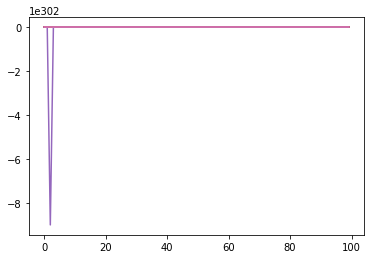

In [32]:
osu= osu_model(rhs)
osu.new_ICs(ICs)
osu.new_soltimes(np.linspace(0, 100, 100))
osu.new_params(paramvals)
OurEnv = ('Weather_data_2020.csv', )
osu.FetchEnviron(OurEnv)
soln = osu.Run()
import matplotlib.pyplot as plt
_ = plt.plot(soln)

In [ ]:
variables = ('S_vt', 'S_lt', 'S_at', 'S_wt', 'S_bt', 'S_yt', 'S_gt' )

parameters  = ('theta_vr', 'theta_vd', 'theta_vo', 'theta_vs', 'theta_vq', 'theta_ps', 'theta_pr', 'theta_pm','theta_tr',
              'theta_td', 'theta_t0', 'theta_alpha', 'theta_el', 'theta_k', 'theta_sr', 'theta_sm','theta_gx','theta_m',
              'theta_gb', 'theta_ts', 'theta_rue', 'theta_a', 'S_xl', 'k_i', 'k_m', 'k_e')

params0 = [0.]*len(variables)*len(parameters)
t = np.linspace(0, 100, 100)
osujacobean  = Build_Jacobean(rhs, variables, ICs + params0, parameters, paramvals )
solution = osujacobean.Run_Model(['Weather_data_2020.csv'], t) 
_ = plt.plot(solution)


In [34]:
class Generate_Fisher_Matrix(Build_Jacobean):
    def __init__(self, environments=[['Weather_data_2020.csv']],covmatrix=None, betavector=0, w=np.linspace(0, 100, 100)):

        self.Build_Jacobean_instance = Build_Jacobean(rhs,variables, ICs + params0, parameters, paramvals)
        self.environments = environments
        self.covmatrix = covmatrix
        self.betavector = betavector
        self.w = w
    def  Simulate(self, ICs, paramvals, t):
        simulation = []
        for environment in self.environments:
          soln = self.Build_Jacobean_instance.Run_Model(environment, t)
          simulation.append(soln)
        self.simulation = np.array(simulation)
        return self.simulation
       
    def Residuals(self, i):
        mean = [0]*np.array(self.covmatrix).shape[0]
        cov = self.covmatrix  
        randomvector =   np.random.multivariate_normal(mean, cov, len(w)).T    

        diagonalmatrix = np.diag(self.simulation[0][i])
        diagonalmatrix_beta_2 =  diagonalmatrix ** (beta/2)
        res = diagonalmatrix_beta_2*self.covmatrix*diagonalmatrix_beta_2
        return 
        
    def du_dr_i(self,i):
        pass
    def da_dth8_k_div_a(self, k, i):
        pass
    def du_dth8_k(self, k, i):
        pass
    def dS_dth8_k(self, k, i):
        pass
    def S_matrix(self):
        pass
class Analyse_S_matrix:
    def __init__(self):
        pass
    def S_test(self):
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:35: RuntimeWarning: invalid value encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: x * g))
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in double_scalars
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_v

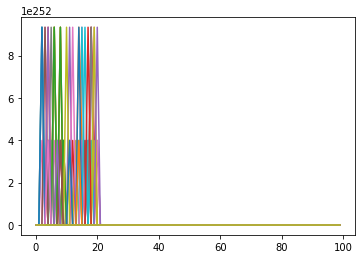

In [35]:
environments = [['Weather_data_2020.csv'], ['Weather_data_2020.csv']]
a = np.zeros((7, 7))
np.fill_diagonal(a, 5)
beta = np.arange(7)
w = np.linspace(0, 100, 100)
osufisher = Generate_Fisher_Matrix(environments, a,betavector=beta,w=w)
simulation = osufisher.Simulate(ICs, paramvals, np.linspace(0, 100, 100))
_ = plt.plot(simulation[0])